## Forecasting Client churn in a telecom company

The telecommunications operator "NoMoreDisconnections.com" wants to learn how to predict customer churn. If it turns out that a user is planning to leave, they will be offered promo codes and special conditions. The operator's team has gathered personal data about certain customers, information about their tariffs, and contracts.

Service Description
The operator provides two main types of services:

Landline telephone communication. It's possible to connect a telephone device to multiple lines simultaneously.
Internet. Connection can be of two types: via a telephone line (DSL, short for digital subscriber line) or fiber optic cable (Fiber optic).
The following services are also available:
• Internet security: antivirus (DeviceProtection) and blocking of unsafe websites (OnlineSecurity);
• Dedicated technical support line (TechSupport);
• Cloud file storage for data backup (OnlineBackup);
• Streaming television (StreamingTV) and a movie catalog (StreamingMovies).
Customers can pay for the services every month or enter into a contract for 1–2 years. Various payment methods are available, as well as the option to receive an electronic receipt.


The data consists of files obtained from different sources:

contract.csv — contract information;
personal.csv — customer's personal data;
internet.csv — information about internet services;
phone.csv — information about phone services.
In all files, the customerID column contains the customer's code. The contract information is up to date as of February 1, 2020.


In [2]:
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier

### Информация о договоре

In [3]:
pth1 = '/datasets/final_provider/contract.csv'
pth2 = 'C:/Users/n.kirpichnikov/Desktop/Apprenticeship/Projects/final_telecom/final_provider/contract.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1 )
elif os.path.exists(pth2):
    contract = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
print(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


In [4]:
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


#### BeginDate

In [6]:
contract['BeginDate'].value_counts()

2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

In [7]:
contract['BeginDate'].describe()

count           7043
unique            77
top       2014-02-01
freq             366
Name: BeginDate, dtype: object

#### EndDate

Based on the EndDate column, you can determine whether a customer has churned or not. If there is a date in this column, it means the customer has churned. If there is no date, the customer is still active.

In [6]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Text(0, 0.5, 'Количество клиентов')

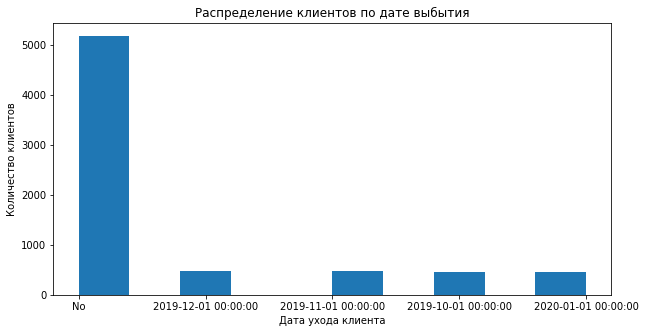

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(contract['EndDate'], bins =10)
plt.title("Распределение клиентов по дате выбытия")
plt.xlabel('Дата ухода клиента')

plt.ylabel('Количество клиентов')


<div class='alert alert-success'> 👍

We can see that the majority of our customers have the "No" label, indicating that they are still active.

#### The contract duration.

To calculate the customer lifespan:

Replace "No" with NaN in the EndDate column.
Convert both columns to the datetime data type.
Subtract BeginDate from EndDate.

In [18]:
contract['EndDate']=contract['EndDate'].replace('No', np.nan)

In [19]:
contract['EndDate'].value_counts()

2019-11-01 00:00:00    485
2019-12-01 00:00:00    466
2020-01-01 00:00:00    460
2019-10-01 00:00:00    458
Name: EndDate, dtype: int64

In [20]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [21]:
contract['BeginDate']= pd.to_datetime(contract['BeginDate'])

In [22]:
print(contract.dtypes)


customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object


In [23]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [24]:
contract['Lifespan'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [10]:
def get_contract_duration(row):
    
    if pd.isnull(row['EndDate']):
        return int((pd.to_datetime('2020-02-01') - row['BeginDate'])  / np.timedelta64(1, 'M'))
    else:
        return int((row['EndDate'] - row['BeginDate']) / np.timedelta64(1, 'M'))

In [25]:
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lifespan
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0


In [26]:
contract['Lifespan'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: Lifespan, dtype: float64

Text(0, 0.5, 'Number of customers')

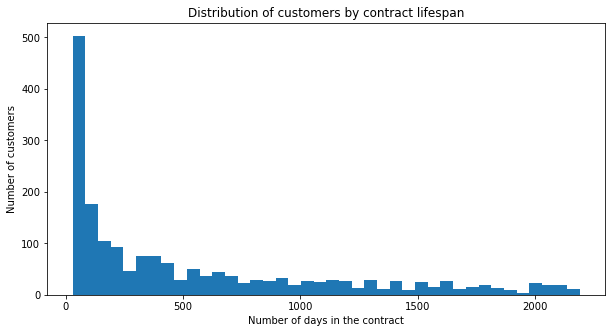

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(contract['Lifespan'], bins =40)
plt.title("Distribution of customers by contract lifespan")
plt.xlabel('Number of days in the contract')

plt.ylabel('Number of customers')


"We can see that the majority of churned customers used the contract for up to 10 days."

Let's add a column with a target feature and name it "Discontinued." If a customer has left (EndDate is not equal to 01.02.2020), we'll assign 1. If a customer has stayed (date is equal to 01.02.2020), we'll assign 0.

In [35]:
contract['Discontinued']=(~contract['EndDate'].isnull()).astype(int)

In [36]:
contract['Discontinued'].value_counts()

0    5174
1    1869
Name: Discontinued, dtype: int64

In [37]:
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lifespan,Discontinued
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,1


#### Payment Type

In [38]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

<AxesSubplot:>

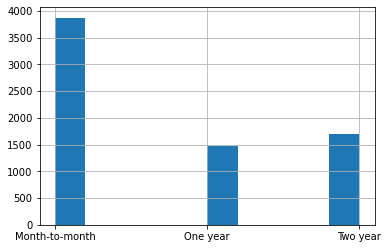

In [39]:
contract['Type'].hist()

The majority of customers pay on a monthly basis.

#### Non-cash payment

In [40]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

<AxesSubplot:>

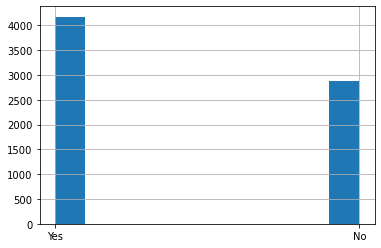

In [41]:
contract['PaperlessBilling'].hist()

The majority prefers to pay by non-cash methods, but it only slightly exceeds cash payment.

#### Payment Method

In [26]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

<AxesSubplot:>

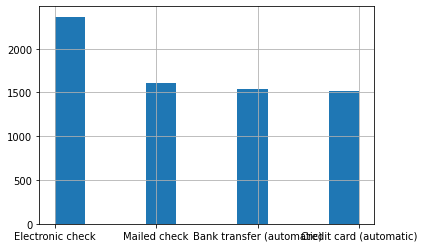

In [27]:
contract['PaymentMethod'].hist()

The payment methods are distributed quite evenly

#### Monthly expenses on services

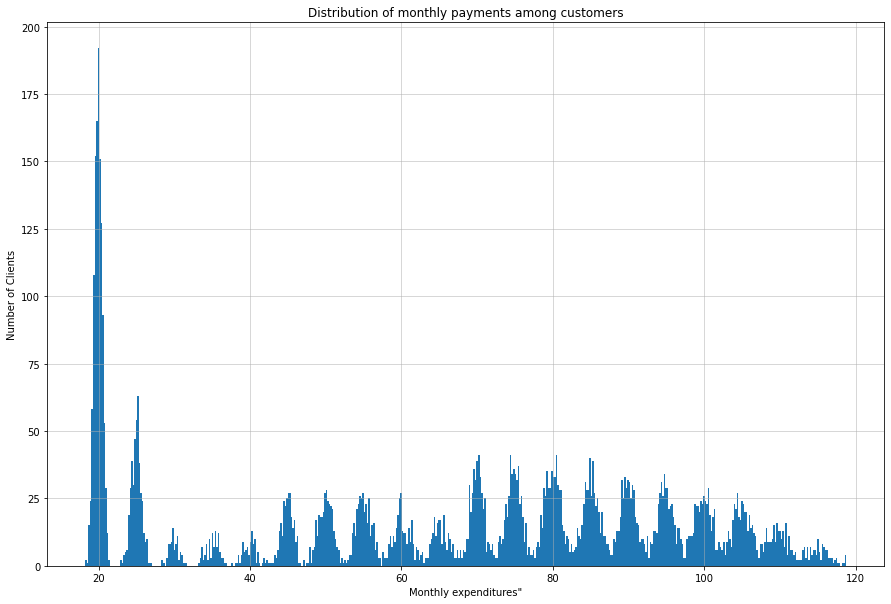

In [42]:
contract['MonthlyCharges'].hist(bins=500, figsize=(15, 10))
plt.xlabel('Monthly expenditures"')
plt.ylabel('Number of Clients')
plt.grid(linewidth=0.5)
plt.title('Distribution of monthly payments among customers')
plt.show()

#### Total charges

In [29]:
contract['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
5420.65     1
5231.2      1
426.35      1
1343.4      1
3181.8      1
Name: TotalCharges, Length: 6531, dtype: int64

In [30]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientDuration,Discontinued
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,0,0


We can see that there are missing values in 'TotalCharges,' even though there are monthly charges present for the month and the 'BeginDate' for all these customers is February 2020. This means that 'TotalCharges' is equivalent to the expenses for the month. The system just hasn't aggregated them into the total charges yet. We will replace these missing values with the monthly charges.

In [31]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract.loc[contract['TotalCharges'] == ' ', 'MonthlyCharges']

Let's change the data type to float.

In [32]:
contract['TotalCharges']=contract['TotalCharges'].astype('float')

<AxesSubplot:>

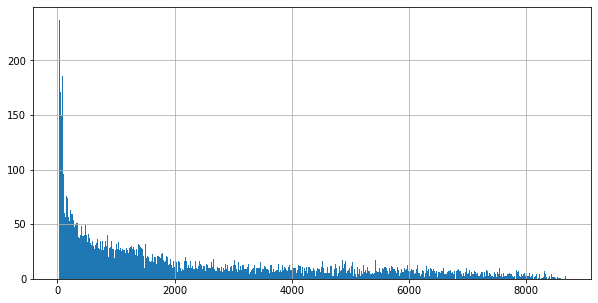

In [33]:
contract['TotalCharges'].hist(bins=500, figsize=(10,5))

### Customers' personal information

In [46]:
pth1 = '/datasets/final_provider/personal.csv'
pth2 = 'C:/Users/n.kirpichnikov/Desktop/Apprenticeship/Projects/final_telecom/final_provider/personal.csv'

if os.path.exists(pth1):
    personal = pd.read_csv(pth1)
elif os.path.exists(pth2):
    personal = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [47]:
print(personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [48]:
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


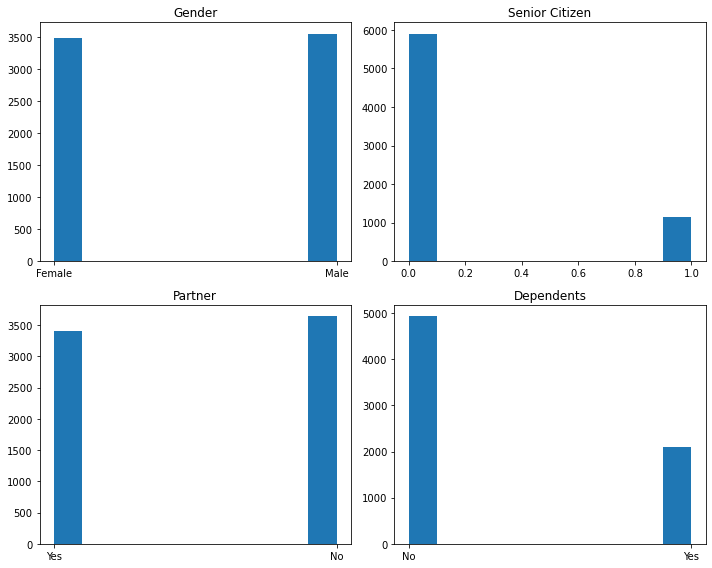

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot 'gender' histogram
axes[0, 0].hist(personal['gender'])
axes[0, 0].set_title('Gender')

# Plot 'SeniorCitizen' histogram
axes[0, 1].hist(personal['SeniorCitizen'])
axes[0, 1].set_title('Senior Citizen')

# Plot 'Partner' histogram
axes[1, 0].hist(personal['Partner'])
axes[1, 0].set_title('Partner')

# Plot 'Dependents' histogram
axes[1, 1].hist(personal['Dependents'])
axes[1, 1].set_title('Dependents')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Users are roughly equally represented by males and females

There are significantly fewer individuals with a pensioner status compared to those without it. 

Users are also almost evenly divided between married and single individuals

The number of customers with children is nearly half that of customers without children

### Информация об интернет-услугах

In [54]:
pth1 = '/datasets/final_provider/internet.csv'
pth2 = 'C:/Users/n.kirpichnikov/Desktop/Apprenticeship/Projects/final_telecom/final_provider/internet.csv'

if os.path.exists(pth1):
    internet = pd.read_csv(pth1)
elif os.path.exists(pth2):
    internet = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [55]:
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


In [56]:
display(internet.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [57]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [58]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [59]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [60]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [61]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [62]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [63]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [51]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Lets visualize these numbers

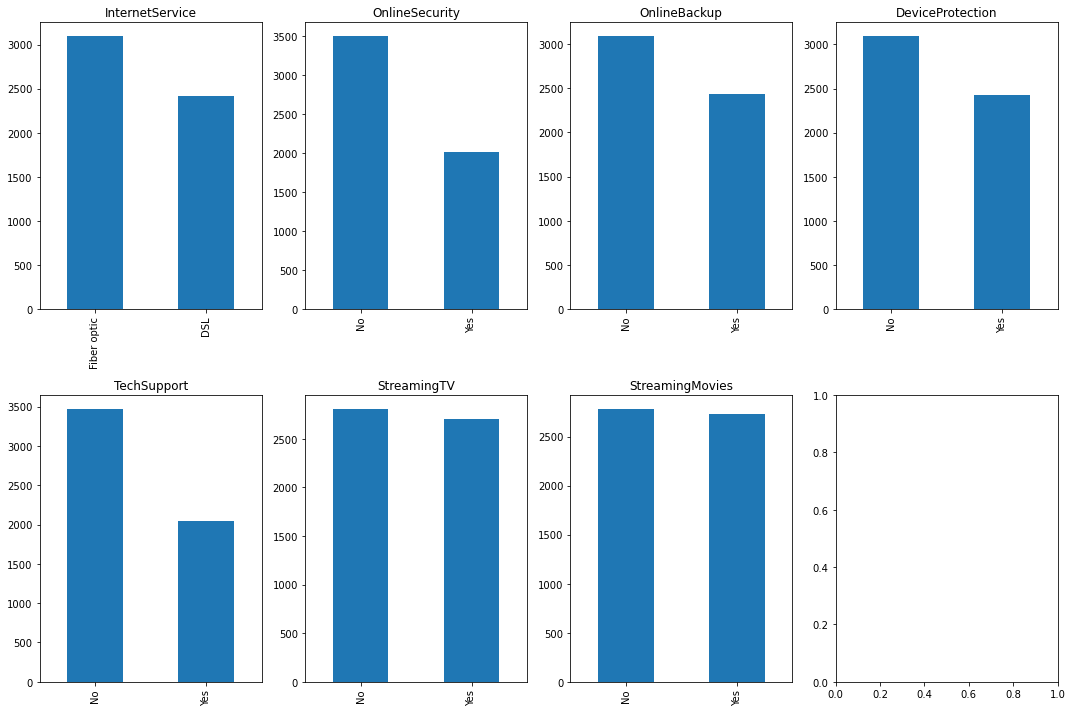

In [64]:
column_names = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Iterate through column names and plot counts
for idx, column_name in enumerate(column_names):
    row_idx = idx // 4
    col_idx = idx % 4
    counts = internet[column_name].value_counts()
    counts.plot(kind='bar', ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(column_name)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



### Telephony Services Information

In [71]:
pth1 = '/datasets/final_provider/phone.csv'
pth2 = 'C:/Users/n.kirpichnikov/Desktop/Apprenticeship/Projects/final_telecom/final_provider/phone.csv'

if os.path.exists(pth1):
    phone = pd.read_csv(pth1)
elif os.path.exists(pth2):
    phone = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [72]:
print(phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [73]:
display(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<AxesSubplot:>

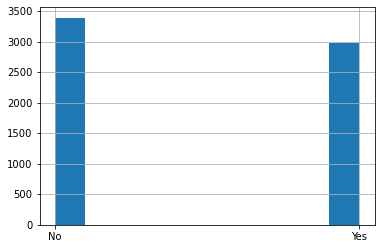

In [74]:
phone['MultipleLines'].hist()

Approximately half of the customers have the presence of parallel lines during a call.

### Conclusion from Exploratory Data Analysis

We have the data with data on 7043 customers of the telecommunications operator. We have the following information about them:

BeginDate - the date of starting to use services,

EndDate - the date of ending the services usage,

Type - payment type: monthly, yearly, etc.,

PaperlessBilling - paperless billing option,

PaymentMethod - payment method,

MonthlyCharges - monthly expenses on services,

TotalCharges - total amount spent on services,

Gender - gender,

Dependents - presence of dependents,

Senior Citizen - presence of senior citizen status based on age,

Partner - presence of partner/spouse,

MultipleLines - availability of parallel lines during calls."






We have separated the target feature into a separate column called 'Discontinued.' Customers with a date in the 'EndDate' column are considered discontinued (1), while customers without a date in the 'EndDate' column are considered current (0).

We have also added another feature - the 'ClientDuration' column, which represents the difference between 'EndDate' and 'BeginDate

In addition, we replaced missing values in the 'TotalCharges' column.

### Let's combine the tables.

In [75]:
data = contract.merge(right=personal, on='customerID', validate='one_to_one')


In [76]:
display (data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lifespan,Discontinued,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,0,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,NaN,0,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,1,Male,0,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,0,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,1,Female,0,No,No


In [77]:
data = data.merge(right=internet, how='left', on='customerID')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lifespan,Discontinued,...,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,0,...,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,NaN,0,...,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,1,...,0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,0,...,0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,1,...,0,No,No,Fiber optic,No,No,No,No,No,No


In [78]:
data = data.merge(right=phone, how='left', on='customerID')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lifespan,Discontinued,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,0,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,NaN,0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,1,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,1,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Lifespan          1869 non-null   float64       
 9   Discontinued      7043 non-null   int32         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

We can observe that not all features have information for all 7043 customers. For example, regarding internet data, there is information only for 5517 users, and for phone lines, data is available for only 6361 users. All the missing values are related to categorical features.

Let's replace the missing values

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Lifespan          1869 non-null   float64       
 9   Discontinued      7043 non-null   int32         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

In [81]:
data['PaperlessBilling'] = data['PaperlessBilling'].astype('category')

In [82]:
data['PaymentMethod'] = data['PaymentMethod'].astype('category')

In [83]:
data['gender'] = data['gender'].astype('category')

In [84]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')

In [85]:
data['Partner'] = data['Partner'].astype('category')

In [86]:
data['Dependents'] = data['Dependents'].astype('category')

In [87]:
data['InternetService'] = data['InternetService'].astype('category')

In [88]:
data['OnlineSecurity'] = data['OnlineSecurity'].astype('category')

In [89]:
data['OnlineBackup'] = data['OnlineBackup'].astype('category')

In [90]:
data['DeviceProtection'] = data['DeviceProtection'].astype('category')

In [91]:
data['TechSupport'] = data['TechSupport'].astype('category')

In [92]:
data['StreamingTV'] = data['StreamingTV'].astype('category')

In [93]:
data['StreamingMovies'] = data['StreamingMovies'].astype('category')

In [94]:
data['MultipleLines'] = data['MultipleLines'].astype('category')

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Lifespan          1869 non-null   float64       
 9   Discontinued      7043 non-null   int32         
 10  gender            7043 non-null   category      
 11  SeniorCitizen     7043 non-null   category      
 12  Partner           7043 non-null   category      
 13  Dependents        7043 non-null   category      
 14  InternetService   5517 n

In [96]:
print(data['Discontinued'])

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Discontinued, Length: 7043, dtype: int32


In [97]:
for column in internet.columns[1:]:
    if column == 'InternetService':
        data[column].cat.add_categories('No', inplace=True)
    
    data[column].fillna('No', inplace=True)
    


In [98]:
data['MultipleLines'].cat.add_categories('No Phone', inplace=True)
data['MultipleLines'].fillna('No Phone', inplace=True)

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Lifespan          1869 non-null   float64       
 9   Discontinued      7043 non-null   int32         
 10  gender            7043 non-null   category      
 11  SeniorCitizen     7043 non-null   category      
 12  Partner           7043 non-null   category      
 13  Dependents        7043 non-null   category      
 14  InternetService   7043 n

In [100]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [101]:
import phik

In [102]:
phik_matrix = data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Lifespan', 'Discontinued']


In [103]:
print(phik_matrix)

                  customerID  BeginDate   EndDate      Type  PaperlessBilling  \
customerID               1.0   1.000000  1.000000  1.000000          1.000000   
BeginDate                1.0   1.000000  0.628089  0.766249          0.081447   
EndDate                  1.0   0.628089  1.000000  0.041080          0.047619   
Type                     1.0   0.766249  0.041080  1.000000          0.106860   
PaperlessBilling         1.0   0.081447  0.047619  0.106860          1.000000   
PaymentMethod            1.0   0.456389  0.000000  0.277462          0.370495   
MonthlyCharges           1.0   0.421886  0.000000  0.388444          0.467812   
TotalCharges             1.0   0.819343  0.060300  0.507638          0.205050   
Lifespan                 1.0   0.993872  0.000000  0.618362          0.115038   
Discontinued             1.0   0.495211       NaN  0.251639          0.295754   
gender                   1.0   0.011268  0.000000  0.000000          0.000000   
SeniorCitizen            1.0

Values between 0 and 0.3: Indicates a weak association between the variables.

Values between 0.3 and 0.5: Suggests a moderate association.

Values between 0.5 and 0.7: Indicates a substantial association.

Values above 0.7: Suggests a strong association.

Lets visualize correlation matrix

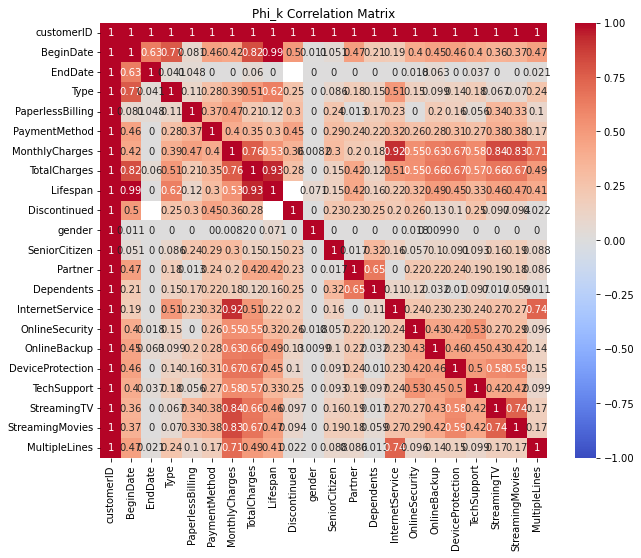

In [106]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Phi_k Correlation Matrix")
plt.show()








The darker the red color the stronger is relation between features. E.g. Monthly charges strongly depend on type of internet services (Fyber optic or DSL), streaming TV, streaming movies and multiple lines. Moderate relation exists between monthly charges and online backup, device protection, techsupport, online security. At the same time monthly charges do not depend on personal features like partner, gender and Senior citizenship.   

### Work plan

We are about to solve a classification task. Let's outline the main stages of work:

1. Exploratory Data Analysis and Data Preprocessing (data familiarization, data visualization, handling missing values, anomalies)

2. Model Building (data splitting into training and testing sets, creating pipelines, feature encoding and scaling, hyperparameter tuning using grid search)

3. Optimal Model Selection (metric calculation, cross-validation).

4. Evaluation of the Optimal Model on the Test Set

5. Compilation of a Report on the Accomplished Work and Achieved Results

## Data Splitting into Subsets

Removing Unnecessary Columns

In [110]:
data=data.drop(['customerID','BeginDate','EndDate'], axis=1)

In [111]:
features=data.drop(['Discontinued'], axis=1)

In [112]:
target= data['Discontinued']

In [113]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=261222)

Let's check the size of the train and test sets

In [114]:
print("Training set - Features:", features_train.shape, "Target:", target_train.shape)
print("Testing set - Features:", features_test.shape, "Target:", target_test.shape)

Training set - Features: (5634, 18) Target: (5634,)
Testing set - Features: (1409, 18) Target: (1409,)


Training set:

Features: (5634, 18) - This means we have 5634 samples (rows) and 18 features (columns) in our training data.
Target: (5634,) - This means we have 5634 corresponding target values in our training set.

Testing set:

Features: (1409, 18) - This means you have 1409 samples (rows) and 18 features (columns) in your testing data.
Target: (1409,) - This means you have 1409 corresponding target values in your testing set.

In both the training and testing sets, we have 18 features for each sample, and the number of target values matches the number of samples. This distribution is expected and indicates that our data splitting was successful.







In [86]:
numerics = ['MonthlyCharges', 'TotalCharges']

In [87]:
categories=['Type','PaperlessBilling', 'PaymentMethod', 'ClientDuration', 'gender','Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [88]:
ohe_transformer = make_column_transformer((StandardScaler(), numerics),
        (OneHotEncoder(drop='first'), categories),
        remainder='passthrough')

### Logistic Regression

In [89]:
pipe_logreg = Pipeline([('transformer', ohe_transformer),
                 ('regression', LogisticRegression(max_iter=200, class_weight='balanced', random_state=261222, n_jobs=1))])

In [90]:
params_logreg = {
    'regression__C': np.geomspace(1e-4, 1000, 1000)
}

In [91]:
logreg_grid = GridSearchCV(
    pipe_logreg,
    param_grid=params_logreg,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=-1,
    refit='roc_auc',
    verbose=5,
    return_train_score=True
)

In [92]:
logreg_grid.fit(features_train, target_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5] END regression__C=0.0001; accuracy: (train=0.756, test=0.729) roc_auc: (train=0.834, test=0.795) total time=   0.1s
[CV 2/5] END regression__C=0.0001; accuracy: (train=0.750, test=0.758) roc_auc: (train=0.832, test=0.813) total time=   0.1s
[CV 3/5] END regression__C=0.0001; accuracy: (train=0.750, test=0.765) roc_auc: (train=0.824, test=0.849) total time=   0.1s
[CV 4/5] END regression__C=0.0001; accuracy: (train=0.756, test=0.739) roc_auc: (train=0.832, test=0.817) total time=   0.1s
[CV 5/5] END regression__C=0.0001; accuracy: (train=0.746, test=0.762) roc_auc: (train=0.820, test=0.860) total time=   0.1s
[CV 1/5] END regression__C=0.00010162650893929952; accuracy: (train=0.756, test=0.730) roc_auc: (train=0.834, test=0.795) total time=   0.1s
[CV 2/5] END regression__C=0.00010162650893929952; accuracy: (train=0.750, test=0.758) roc_auc: (train=0.832, test=0.813) total time=   0.1s
[CV 3/5] END regression__C=0

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                     

In [93]:
results = logreg_grid.cv_results_
best_index = logreg_grid.best_index_


In [94]:
logreg_fit_time = results['mean_fit_time'][best_index]
logreg_score_time = results['mean_score_time'][best_index]
logreg_roc_auc = (logreg_grid.best_score_)

In [96]:
# dataframe to analyse models 
model_data = pd.DataFrame(columns=('model','fit_time','score_time','roc_auc'))
model_data.head()

,model,fit_time,score_time,roc_auc


In [97]:
logreg_data = ['LogisticRegression', logreg_fit_time, logreg_score_time, logreg_roc_auc]

#add to dataframe
model_data.loc[len(model_data)] = logreg_data
model_data.head()

,model,fit_time,score_time,roc_auc
0,LogisticRegression,0.226123,0.030406,0.862261


### Random Forest

In [98]:
oe_transformer = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categories),
        remainder='passthrough')

In [99]:
pipe_rf = Pipeline([('oe_transformer', oe_transformer),
                 ('rf', RandomForestClassifier(class_weight='balanced', random_state=261222))])


In [100]:
param = {'rf__max_depth':[10,20,30],
        'rf__n_estimators':[100,200,300]}

In [101]:
rf_grid=GridSearchCV(estimator=pipe_rf, cv=5, param_grid = param, scoring=['roc_auc', 'accuracy'], n_jobs=-1,  refit='roc_auc',
    verbose=5,
    return_train_score=True)
rf_grid=rf_grid.fit(features_train, target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END rf__max_depth=10, rf__n_estimators=100; accuracy: (train=0.886, test=0.786) roc_auc: (train=0.959, test=0.836) total time=   0.5s
[CV 2/5] END rf__max_depth=10, rf__n_estimators=100; accuracy: (train=0.883, test=0.792) roc_auc: (train=0.959, test=0.841) total time=   0.5s
[CV 3/5] END rf__max_depth=10, rf__n_estimators=100; accuracy: (train=0.888, test=0.808) roc_auc: (train=0.959, test=0.865) total time=   0.5s
[CV 4/5] END rf__max_depth=10, rf__n_estimators=100; accuracy: (train=0.887, test=0.779) roc_auc: (train=0.960, test=0.843) total time=   0.5s
[CV 5/5] END rf__max_depth=10, rf__n_estimators=100; accuracy: (train=0.885, test=0.806) roc_auc: (train=0.959, test=0.883) total time=   0.6s
[CV 1/5] END rf__max_depth=10, rf__n_estimators=200; accuracy: (train=0.888, test=0.786) roc_auc: (train=0.959, test=0.838) total time=   1.3s
[CV 2/5] END rf__max_depth=10, rf__n_estimators=200; accuracy: (train=0.884, test=

In [102]:
results = rf_grid.cv_results_
best_index = rf_grid.best_index_

In [103]:
rf_fit_time = results['mean_fit_time'][best_index]
rf_score_time = results['mean_score_time'][best_index]
rf_roc_auc = (rf_grid.best_score_)


In [104]:
rf_data = ['RandomForest', rf_fit_time, rf_score_time, rf_roc_auc]

model_data.loc[len(model_data)] = rf_data
model_data.head()

,model,fit_time,score_time,roc_auc
0,LogisticRegression,0.226123,0.030406,0.862261
1,RandomForest,1.385087,0.203790,0.854676


### Catboost

In [105]:
from catboost import CatBoostClassifier

cat_features=['PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines' ]

In [106]:
model_cbr = CatBoostClassifier(auto_class_weights='Balanced', random_state=261222, thread_count=1)


In [107]:
grid_parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }


In [108]:
cbr_grid = GridSearchCV(estimator=model_cbr, param_grid = grid_parameters, cv = 5, n_jobs=-1,  scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    verbose=5,
    return_train_score=True)


In [109]:
cbr_grid.fit(features_train, target_train, cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], verbose=0)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END depth=6, iterations=30, learning_rate=0.01; accuracy: (train=0.738, test=0.713) roc_auc: (train=0.838, test=0.802) total time=   0.6s
[CV 2/5] END depth=6, iterations=30, learning_rate=0.01; accuracy: (train=0.723, test=0.715) roc_auc: (train=0.835, test=0.817) total time=   0.6s
[CV 3/5] END depth=6, iterations=30, learning_rate=0.01; accuracy: (train=0.683, test=0.705) roc_auc: (train=0.831, test=0.854) total time=   0.6s
[CV 4/5] END depth=6, iterations=30, learning_rate=0.01; accuracy: (train=0.721, test=0.689) roc_auc: (train=0.834, test=0.818) total time=   0.5s
[CV 5/5] END depth=6, iterations=30, learning_rate=0.01; accuracy: (train=0.700, test=0.714) roc_auc: (train=0.828, test=0.857) total time=   0.6s
[CV 1/5] END depth=6, iterations=30, learning_rate=0.05; accuracy: (train=0.751, test=0.727) roc_auc: (train=0.852, test=0.812) total time=   0.6s
[CV 2/5] END depth=6, iterations=30, learning_rate=0.05;

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fcbc10867f0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy'], verbose=5)

In [110]:
results = cbr_grid.cv_results_

best_index = cbr_grid.best_index_


fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
roc_auc = (cbr_grid.best_score_)

In [111]:
catboost_data = ['CatBoost', fit_time, score_time, roc_auc]

model_data.loc[len(model_data)] = catboost_data
model_data.head()

,model,fit_time,score_time,roc_auc
0,LogisticRegression,0.226123,0.030406,0.862261
1,RandomForest,1.385087,0.203790,0.854676
2,CatBoost,0.840405,0.011921,0.865535


### Models Analysis

,model,fit_time,score_time,roc_auc
0,LogisticRegression,0.226123,0.030406,0.862261
1,RandomForest,1.385087,0.203790,0.854676
2,CatBoost,0.840405,0.011921,0.865535


<AxesSubplot:xlabel='model'>

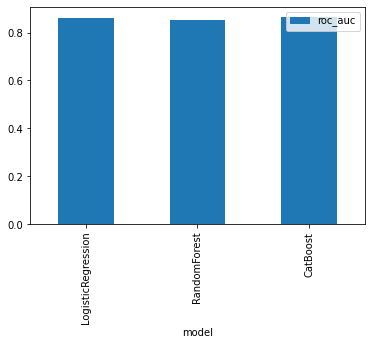

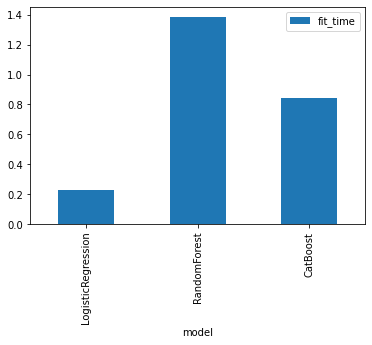

In [112]:
model_data = model_data.drop_duplicates()
display(model_data)
model_data.plot.bar(x='model',y='roc_auc')
model_data.plot.bar(x='model',y='fit_time')

We can observe that the ROC AUC is approximately the same for all models, but slightly better for CatBoost. Therefore, we choose the CatBoost model for testing on the test set.

###  Let's make predictions using the best model and evaluate the ROC AUC.

In [113]:
preds = cbr_grid.predict_proba(features_test)

In [114]:
roc_auc_score(target_test, preds[:, 1])
    

0.8747009739337104

In [115]:
accuracy_score(target_test, cbr_grid.predict(features_test))

0.7721788502484032

###  Analysis of feature importance in the best model.

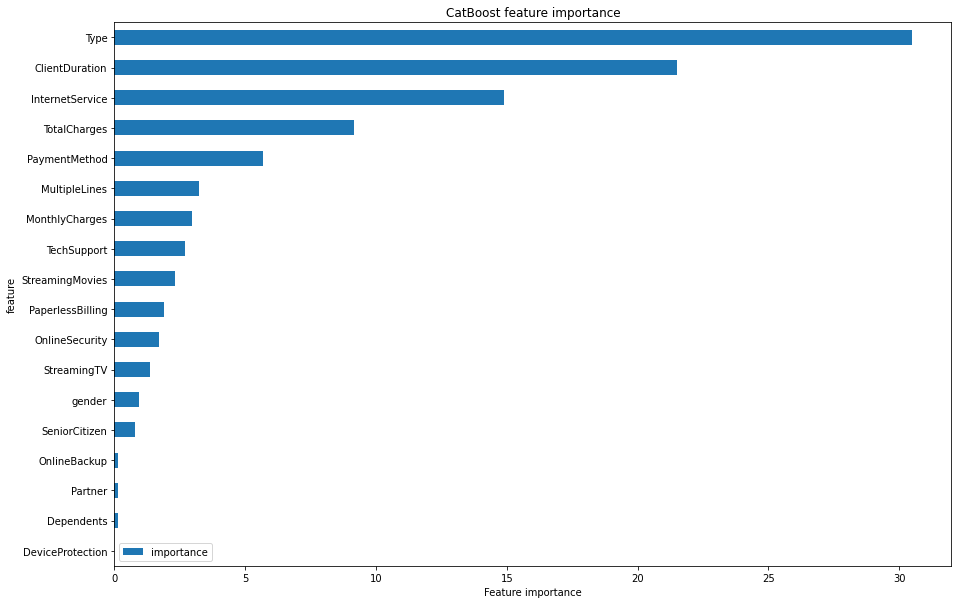

In [119]:
fi = pd.DataFrame({'importance': cbr_grid.best_estimator_.feature_importances_, 'feature': cbr_grid.best_estimator_.feature_names_}).sort_values(by='importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.xlabel('Feature importance')
plt.title('CatBoost feature importance')
plt.show()

The above graph shows the features that the model selected as the most important, including Type, Client Duration, and Internet Service.

The obtained data can be used, for example, for manual dimensionality reduction of the data or simply for a visual representation of the relationship between the target variable and specific features.

###  Confusion matrix

In [131]:
cm=confusion_matrix(target_test, cbr_grid.predict(features_test))


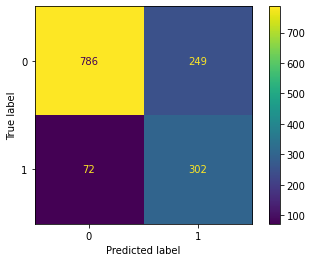

In [136]:
cm_display = ConfusionMatrixDisplay(cm).plot()

Correct predictions 786 (True Positive) + 302 (True Negative) = 1088. The overall accuracy of the model is 1088/1409 = 77%.

##  Conclusion

Throughout the project, we tuned hyperparameters for three models: Random Forest, CatBoost, and Logistic Regression. The optimal model turned out to be CatBoost.

We tested it on the test dataset and achieved the following metrics: ROC AUC of 0.8795 and an accuracy score of 0.7842.